# 시나리오
- 기존에 만들어진 와인 분류 모델의 성능 의심
- max_depth를 3이 아닌 값으로 할 경우 성능은 달라질 수 있음
- 점진적 학습으로 진행하더라도 테스트 세트로만 평가를 하면 테스트 세트에만 잘 맞는 모델로 굳혀지게 됨
- 테스트 세트는 딱 한 번만 이용되는 것이 바람직함
- max_depth의 최적값을 어떻게 찾을 것인가?
- 결정 트리는 테스트에 사용되는 매개변수도 다양함

## 검증 세트
- 테스트 세트를 사용하지 않고 모델의 과대/과소 적합을 판단하려면 혼련 세트를 다시 나누는 방법을 이용
- 전체 데이터에서 훈련세트와 테스트세트를 나누고 훈련세트에서 다시 검증세트를 나누는 것
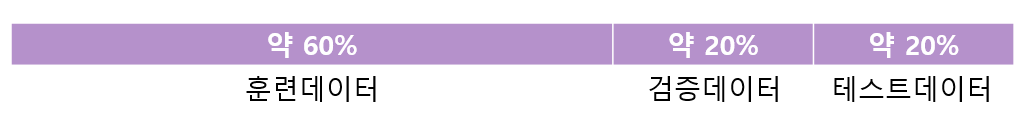

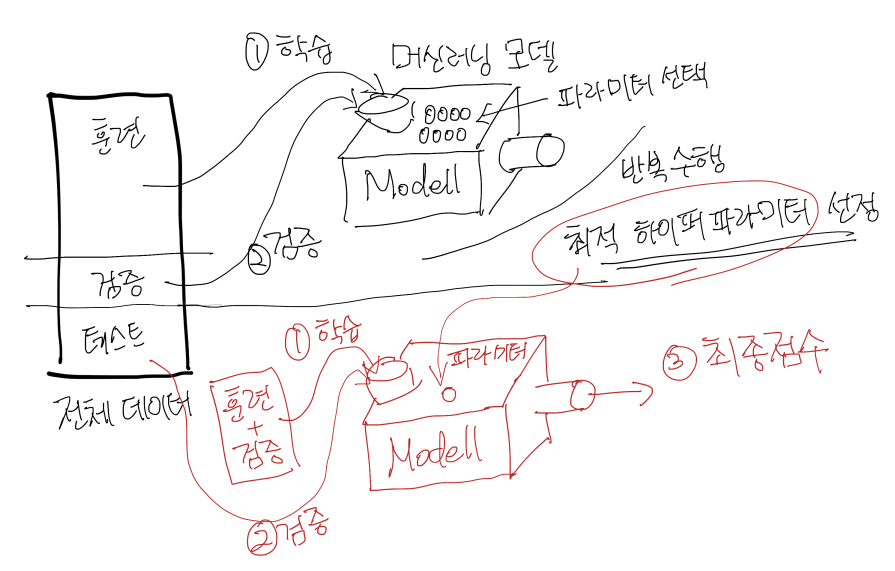
1) 훈련데이터로 모델을 훈련하고 검증 세트로 모델을 평가(매개변수를 변경하면서 좋은 모델을 선택)  
2) 선택된 모델을 이용하여 훈련데이터와 검증데이터롤 합친 데이터로 다시 모델을 훈련  
3) 훈련된 모델을 테스트 데이터로 최종 점수를 평가

### 검증세트 활용

In [1]:
import pandas as pd

wine = pd.read_csv('wine_csv_data.csv')

# class열은 종속변수(y), 나머지는 독립변수(X)
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

#### 데이터 분할(훈련:80, 테스트:20)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:
X_train.shape, y_train.shape

((5197, 3), (5197,))

In [5]:
X_test.shape, y_test.shape

((1300, 3), (1300,))

#### 훈련데이터에서 검증 데이터 분할(훈련:80. 검증:20)

In [6]:
X_train_sub, X_test_valid, y_train_sub, y_test_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [7]:
X_train_sub.shape, X_test_valid.shape

((4157, 3), (1040, 3))

In [8]:
X_test_valid.shape, y_test_valid.shape

((1040, 3), (1040,))

#### 결정트리 모델 학습 및 평가

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_sub, y_train_sub)

print(dt.score(X_train_sub, y_train_sub))
print(dt.score(X_test_valid, y_test_valid))

0.9971133028626413
0.864423076923077


##### 결과
- 훈련세트에 과적합으로 보임
- 매개변수를 변경하여 더 좋은 모델을 만들어야 함

## 교차검증(Cross Validation)
- 현재 검증 세트를 분할하면서 훈련세트가 줄어들었음
- 많은 데이터를 훈련에 사용하면 좋은 모델이 만들어짐
- 검증세트가 너무 적으면 검증 점수의 신뢰성이 떨어짐
- 검증세트를 이용하여 평가하는 과정을 여러 번 반복하여 이 점수들을 평균하여 최종 점수를 얻음

### K-Fold Cross Validation


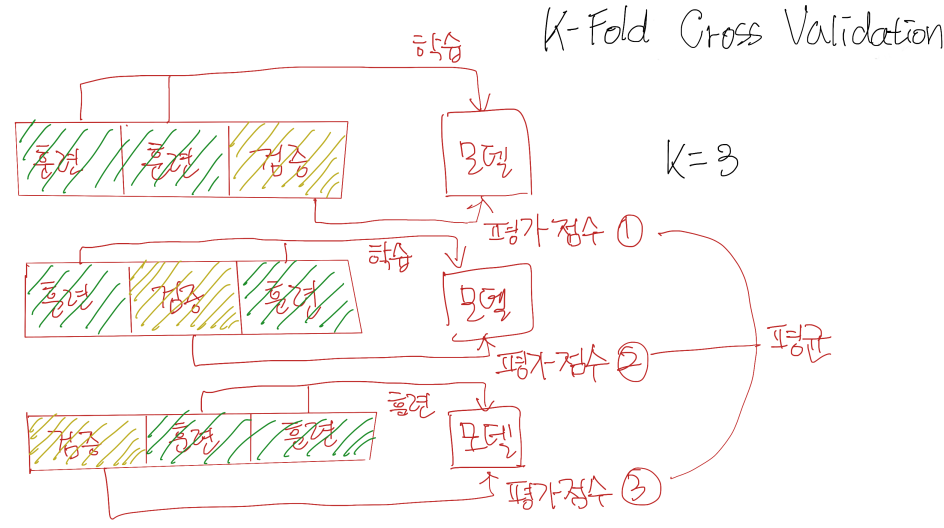
- 보통 5-Fold, 10-Fold를 많이 사용
- 이 방법은 데이터의 80~90%까지 훈련에 사용 가능
- 검증 세트가 줄어들지만 각 폴드에서 계산한 검증 점수의 평균을 사용하므로 신뢰성 확보
- 사이킷런에서 cross_validate() 함수 지원

### 데이터 준비

In [10]:
import pandas as pd

wine = pd.read_csv('wine_csv_data.csv')

# class열은 종속변수(y), 나머지는 독립변수(X)
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

### 모델 준비

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

### 교차검증

In [12]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, X_train, y_train)
scores

{'fit_time': array([0.00561857, 0.00595307, 0.00701237, 0.00595355, 0.00653291]),
 'score_time': array([0.00198936, 0.00102806, 0.00061655, 0.00099802, 0.00099778]),
 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}

##### 결과
- 기본 5폴드 교차 검증 진행
- fit_time: 모델을 훈련하는 시간
- score_time: 모델 검증하는 시간
- test_score: 각 검증 결과 점수

#### 교차검증 최종 점수

In [13]:
import numpy as np

np.mean(scores['test_score'])

0.855300214703487

##### 결과
- 모델을 사용했을 때 최상의 검증 점수를 가늠할 수 있음
- cross_validate()함수는 훈련세트를 섞어서 폴드를 나누지 않음
- train_test_split()을 이용하여 전체 데이터를 섞어서 진행할 수 있음
- 교차검증 시 훈련세트를 섞고자 한다면 분할기(spliter) 지정 필요
    - KFold 분할기는 회귀모델에 사용
    - StratifiedKFold 분할기는 분류모델에 사용

#### 데이터 및 모델 준비

In [14]:
import pandas as pd

wine = pd.read_csv('wine_csv_data.csv')

# class열은 종속변수(y), 나머지는 독립변수(X)
data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

#### StratifiedKFold 검증기 사용하여 교차검증

In [15]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, X_train, y_train, cv=StratifiedKFold())
np.mean(scores['test_score'])

0.855300214703487

#### 폴드 수 조정(n_splits=)

In [16]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_validate(dt, X_train, y_train, cv=splitter)
np.mean(scores['test_score'])

0.8574181117533719

##### 설명
- 가장 좋은 성능의 결정트리를 위해 매개변수 값을 변경하면서 모델을 찾는다.
- 테스트 세트를 사용하지 않고 교차 검증을 통해 모델을 고른다.
- 테스트 세트를 사용하지 않으므로 테스트 세트에만 맞는 모델이 만들어지지 않음